In [1]:
import numpy as np
import pandas as pd
import torch
from scipy.linalg import toeplitz
from scipy.stats import norm

import matplotlib.pyplot as plt
from tableone import TableOne
from sksurv.nonparametric import kaplan_meier_estimator

from utils import data_processing, visualization
from utils.simulations import *
from execute import surv_hivae
#from utils.metrics import log_rank, cox_estimation

In [2]:
n_samples = 600
n_features_bytype = 4
n_features_multiplier = 3 

In [3]:
beta_features = np.concatenate([weights_sparse_exp(n_features_bytype,3),weights_sparse_exp(n_features_bytype,3),
                       weights_sparse_exp(n_features_bytype,3)])
treatment_effect = 0

In [4]:
control, treated, types = simulation(beta_features, treatment_effect , n_samples,surv_type = "surv_weibull")
control = control.drop(columns='treatment')
treated = treated.drop(columns='treatment')

In [5]:
control.head()

,0,1,2,3,4,5,6,7,8,9,10,11,time,censor
0,-1.649375,0.411654,-0.021997,1.363604,0.768931,0.632569,0.602867,0.482281,0.0,0.0,1.0,1.0,0.287707,1
1,-0.587946,-0.643199,0.852715,0.399421,1.869273,2.405626,0.886357,1.060385,0.0,0.0,0.0,1.0,2.623703,1
2,-2.329837,-0.177992,-0.633925,-0.350214,0.596037,0.089699,0.927206,2.160913,0.0,0.0,1.0,1.0,0.974110,1
4,-0.530011,-1.167549,-1.360785,-0.797203,0.588755,0.044592,0.891551,0.398400,0.0,0.0,1.0,1.0,2.166497,1
5,0.094014,-0.910731,-0.121337,0.982458,1.022794,0.347633,2.210802,1.173190,0.0,0.0,1.0,1.0,2.785163,0


In [6]:
print(np.mean(control['censor']),np.mean(treated['censor']))

0.8885245901639345 0.8677966101694915


In [7]:
dataset_name = "Simulations"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
miss_file = "dataset/" + dataset_name + "/Missing.csv"
true_miss_file = None

In [8]:
control.to_csv(data_file_control,index=False , header=False)
types.to_csv(feat_types_file_control)
treated.to_csv(data_file_treated,index=False , header=False)
types.to_csv(feat_types_file_treated)

## Compute expected power / level via Schoenfeld formula

$$D = \frac{(\Phi^{-1}(\beta)+\Phi^{-1}(1-\alpha))^2}{P_{cont}(1 - P_{cont}) log^2(\Delta)}$$
where 
- $D$ is the number of deaths
- $\alpha$ is the level
- $\beta$ is the power
- $P_{cont}$ is the proportion of patients in the control arm
- $\Delta$ is the hazard ratio

D

In [12]:
data = pd.concat([control,treated],ignore_index=True)

data['censor']
D =  np.sum(data['censor'])
print(D)

527


In [13]:
alpha = 0.05
p_treated = 0.5
treatment_effect = 0.5
expected_power = norm.cdf(np.sqrt( D * p_treated * (1 - p_treated) * (treatment_effect)**2 ) - norm.ppf(1 - alpha/2))

In [14]:
expected_power

np.float64(0.9999213196391522)

## Generation

In [15]:
# Load and transform control data
data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, 
                                                                                                             feat_types_file_control, 
                                                                                                             miss_file, true_miss_file)
data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)

# Load and transform treated data
data_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, 
                                                         miss_file, true_miss_file)
data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)

In [16]:
data_init_control_encoded

tensor([[-1.6494e+00,  4.1165e-01, -2.1997e-02,  ...,  1.0000e+00,
          2.8771e-01,  1.0000e+00],
        [-5.8795e-01, -6.4320e-01,  8.5272e-01,  ...,  1.0000e+00,
          2.6237e+00,  1.0000e+00],
        [-2.3298e+00, -1.7799e-01, -6.3393e-01,  ...,  1.0000e+00,
          9.7411e-01,  1.0000e+00],
        ...,
        [ 2.0373e-01,  2.4094e-01,  8.9404e-01,  ...,  0.0000e+00,
          2.1271e+00,  1.0000e+00],
        [ 1.7255e-03,  2.8719e-01,  7.0652e-01,  ...,  0.0000e+00,
          3.9041e+00,  1.0000e+00],
        [-1.1859e-02,  8.7573e-01,  6.6440e-01,  ...,  1.0000e+00,
          1.7618e+00,  1.0000e+00]])

In [17]:
data_init_control_encoded.shape

torch.Size([305, 18])

In [18]:
fnames = types['name'][:-1].tolist()
fnames.append("time")#.append("censor")
fnames.append("censor")

In [19]:
feat_types_dict

[{'': '0', 'name': 'feat1', 'type': 'real', 'dim': '1', 'nclass': ''},
 {'': '1', 'name': 'feat2', 'type': 'real', 'dim': '1', 'nclass': ''},
 {'': '2', 'name': 'feat3', 'type': 'real', 'dim': '1', 'nclass': ''},
 {'': '3', 'name': 'feat4', 'type': 'real', 'dim': '1', 'nclass': ''},
 {'': '4', 'name': 'feat5', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'': '5', 'name': 'feat6', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'': '6', 'name': 'feat7', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'': '7', 'name': 'feat8', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'': '8', 'name': 'feat9', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'': '9', 'name': 'feat10', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'': '10', 'name': 'feat11', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'': '11', 'name': 'feat12', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'': '12',
  'name': 'survcens',
  'type': 'surv_weibull',
  'dim': '2',
  'nclass': ''}]

In [20]:
# Format data in dataframe
df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=fnames)
df_init_control = pd.DataFrame(data_init_control.numpy(), columns=fnames)

# Update the data
df_init_treated["treatment"] = 1
df_init_control["treatment"] = 0
df_init = pd.concat([df_init_control, df_init_treated], ignore_index=True)

In [21]:
feat_types_dict_all = feat_types_dict.copy()
feat_types_dict_all.append({'name': 'treatment', 'type': 'cat', 'dim': '1', 'nclass': '2'})
#visualization.plot_data(df_init.to_numpy(), feat_types_dict_all, feat_comparison_name='treatment')

In [22]:
names_cont = []
names_pos = []
names_cat = []
for x in range(1, n_features_bytype   + 1):
            names_pos.append("feat{0}".format(x + n_features_bytype))
            names_cat.append("feat{0}".format(x + 2 * n_features_bytype))

table1 = TableOne(df_init, categorical=names_cat, continuous=names_cont, 
                  groupby='treatment', nonnormal=names_pos, pval=True)
print(table1)

                          Grouped by treatment                                                     
                                       Missing        Overall              0              1 P-Value
n                                                         600            305            295        
feat1, mean (SD)                             0      0.0 (1.0)     -0.0 (1.0)      0.0 (1.0)   0.447
feat2, mean (SD)                             0     -0.0 (1.0)     -0.0 (1.0)     -0.0 (1.0)   0.828
feat3, mean (SD)                             0      0.0 (1.0)      0.0 (1.0)     -0.0 (1.0)   0.566
feat4, mean (SD)                             0      0.0 (1.0)      0.1 (1.0)     -0.1 (1.0)   0.076
feat5, median [Q1,Q3]                        0  0.6 [0.3,1.1]  0.6 [0.3,1.1]  0.7 [0.3,1.1]   0.514
feat6, median [Q1,Q3]                        0  0.7 [0.3,1.1]  0.6 [0.3,1.1]  0.7 [0.3,1.1]   0.201
feat7, median [Q1,Q3]                        0  0.6 [0.3,1.1]  0.6 [0.3,1.1]  0.6 [0.3,1.1]   0.849


In [23]:


# the datasets used for training is data_init_control
n_generated_sample = 10
T_surv = torch.Tensor(df_init_control.time)
T_surv_norm = (T_surv - T_surv.min()) / (T_surv.max() - T_surv.min())
n_intervals = 5
T_intervals = torch.linspace(0., T_surv_norm.max(), n_intervals)
T_intervals = torch.cat([T_intervals, torch.tensor([2 * T_intervals[-1] - T_intervals[-2]])])
intervals = [(T_intervals[i].item(), T_intervals[i + 1].item()) for i in range(len(T_intervals) - 1)]

In [24]:
data_gen_control = surv_hivae.run((data_init_control_encoded, intervals), miss_mask_control, 
                                  true_miss_mask_control, feat_types_file_control, feat_types_dict, n_generated_sample,verbose=False)

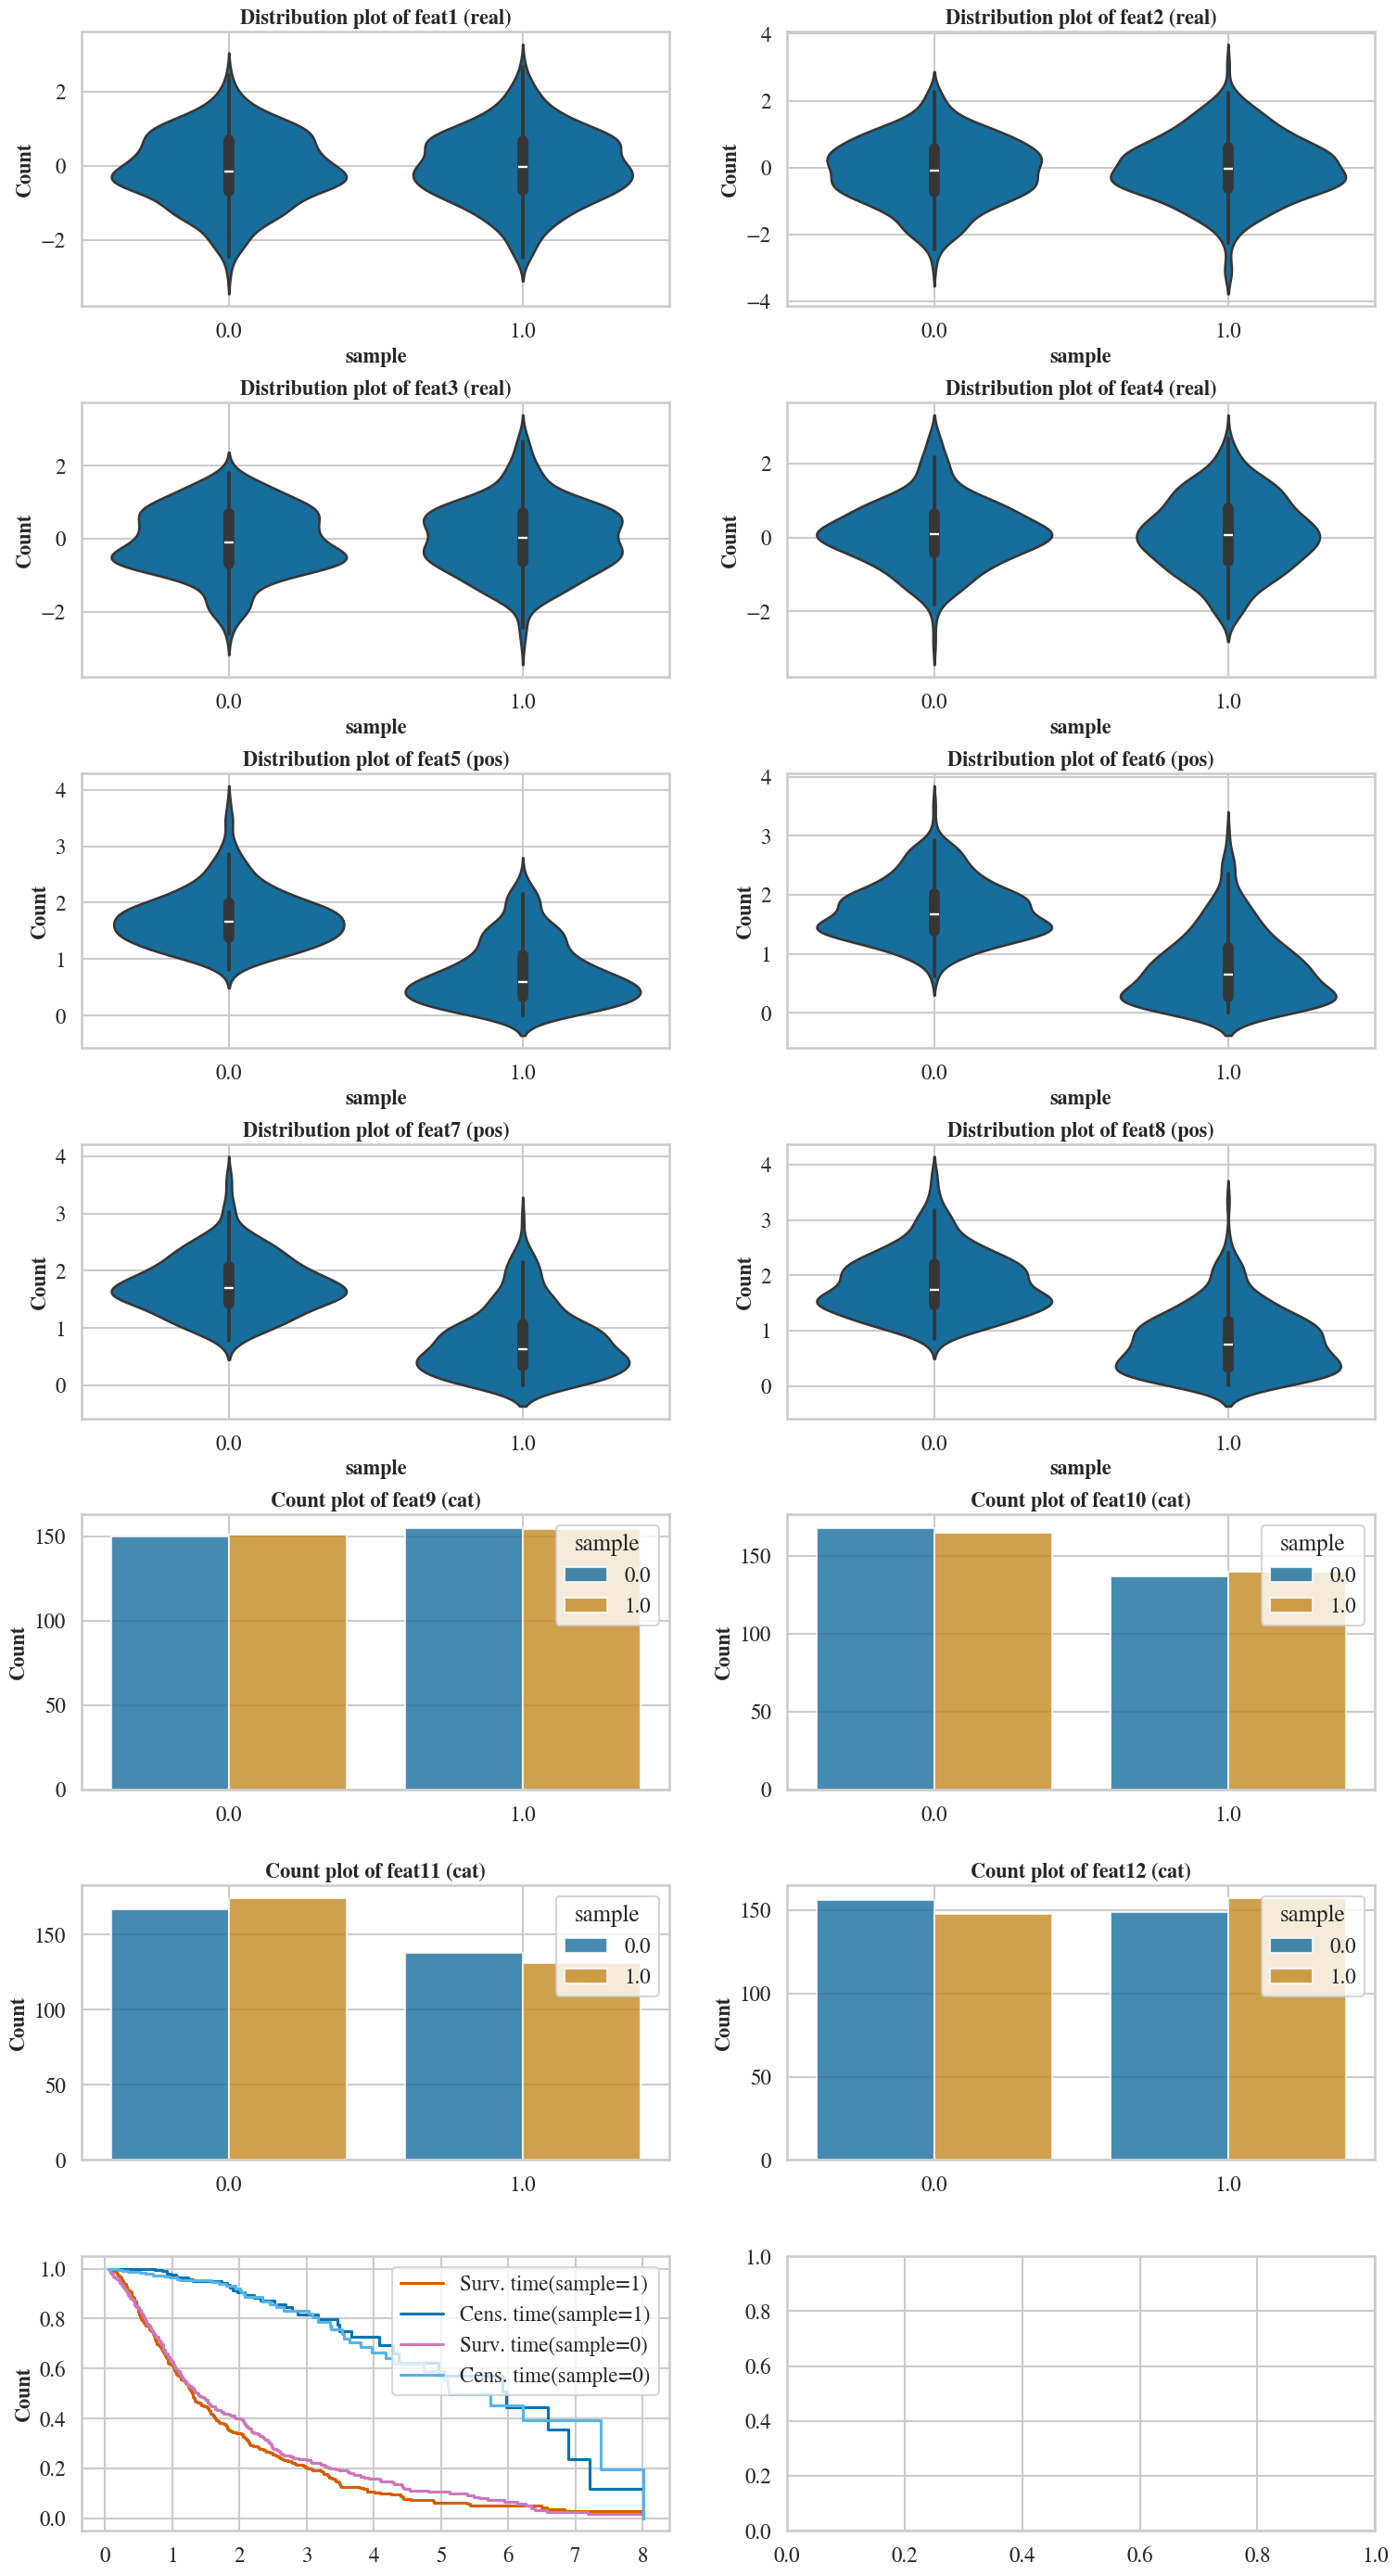

In [25]:
df_init_control_ext = pd.DataFrame(data_init_control.numpy(), columns=fnames)
df_init_control_ext['sample'] = 1

sel_idx = 0
df_gen_control_ext_sel = pd.DataFrame(data_gen_control[sel_idx].numpy(), columns=fnames)
df_gen_control_ext_sel['sample'] = 0

# Save original values before overwriting
#tmp = df_gen_control_ext_sel[['time', 'censor']].copy()

# Replace 'time' with row-wise minimum
#df_gen_control_ext_sel['time'] = tmp.min(axis=1)

# Replace 'censor' with column name of the minimum ('time' or 'censor')
#df_gen_control_ext_sel['censor'] = 1* (tmp.idxmin(axis=1)=='time')
#df_gen_control_ext_sel[]

feat_types_dict_ext = feat_types_dict.copy()
feat_types_dict_ext.append({'name': 'sample', 'type': 'cat', 'dim': '1', 'nclass': '2'})
df_control_sel = pd.concat([df_init_control_ext, df_gen_control_ext_sel], ignore_index=True)
visualization.plot_data(df_control_sel.to_numpy(), feat_types_dict_ext, feat_comparison_name = 'sample')

In [26]:
intervals

[(0.0, 0.25), (0.25, 0.5), (0.5, 0.75), (0.75, 1.0), (1.0, 1.25)]

## Replication

In [30]:
n_generated_dataset = 50
dataset_name = "Simulations"

In [31]:
alphas = np.arange(0,0.4,0.2)
print(alphas)

[0.  0.2]


## Independent

In [ ]:
M = 100
log_p_value = []
log_p_value_gen = []
simu_num = []
H0_coef = []
for t in alphas:
    treatment_effect = t
    for m in np.arange(M):
        if m % 10 == 0:
            print(m)
        control, treated = simulation(beta_features, treatment_effect , n_samples,surv_type = "surv_weibull", data_types_create=False)
        
        control = control.drop(columns='treatment')
        treated = treated.drop(columns='treatment')
        
        data_file_control= "./dataset/" + dataset_name + "/data_control_gen" + str(m) +".csv"
        data_file_treated= "./dataset/" + dataset_name + "/data_treated_gen" + str(m) +".csv"
        
        
        control.to_csv(data_file_control,index=False , header=False)
        treated.to_csv(data_file_treated,index=False , header=False)
        
        df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=fnames)
        df_init_control = pd.DataFrame(data_init_control.numpy(), columns=fnames)
        
        T_surv = torch.Tensor(df_init_control.time)
        T_surv_norm = (T_surv - T_surv.min()) / (T_surv.max() - T_surv.min())
        n_intervals = 5
        T_intervals = torch.linspace(0., T_surv_norm.max(), n_intervals)
        T_intervals = torch.cat([T_intervals, torch.tensor([2 * T_intervals[-1] - T_intervals[-2]])])
        intervals = [(T_intervals[i].item(), T_intervals[i + 1].item()) for i in range(len(T_intervals) - 1)]
        
        p_value_init = compute_logrank_test(control, treated)
    
        
    
        # Load and transform control data
        data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, 
                                                                                                                     feat_types_file_control, 
                                                                                                                     miss_file, true_miss_file)
        data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)
        
        # Load and transform treated data
        data_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, 
                                                                 miss_file, true_miss_file)
        data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)
    
        data_gen_control = surv_hivae.run((data_init_control_encoded, intervals), miss_mask_control, 
                                      true_miss_mask_control, feat_types_file_control, feat_types_dict, n_generated_dataset,verbose=False)
        
        for i in range(n_generated_dataset):
            df_gen_control = pd.DataFrame(data_gen_control[i].numpy(), columns=fnames)
            df_gen_control['treatment'] = 0
            log_p_value.append(p_value_init)
            simu_num.append(m)
            p_value_gen = compute_logrank_test(df_gen_control, treated)
            log_p_value_gen.append(p_value_gen)
            H0_coef.append(treatment_effect)


0


In [52]:

results = pd.DataFrame({'XP_num' : simu_num, "log_pvalue_init" : log_p_value, "log_pvalue_gen" : log_p_value_gen , "H0_coef" : H0_coef})
results["reject_H0_init"] = results['log_pvalue_init'] > -np.log(0.05)
results["reject_H0_gen"] = results['log_pvalue_gen'] > -np.log(0.05)

In [53]:
#results.to_csv("./dataset/" + dataset_name + "results_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".csv")

In [54]:
#alpha = 0.05
#p_treated = 0.5
#expected_power = []
#for treatment_effect in alphas:
#    expected_power.append(norm.cdf(np.sqrt( D / 2 * p_treated * (1 - p_treated) * (treatment_effect)**2 ) - norm.ppf(1 - alpha/2)))

In [55]:
results[results["reject_H0_init"] ==  False].groupby(["H0_coef"]).mean()

,XP_num,log_pvalue_init,log_pvalue_gen,reject_H0_init,reject_H0_gen
H0_coef,,,,,
0.0,49.958763,0.689389,1.100940,0.0,0.068866
0.5,52.731343,1.148979,1.584809,0.0,0.150149
1.0,51.777778,1.790732,1.976639,0.0,0.215556


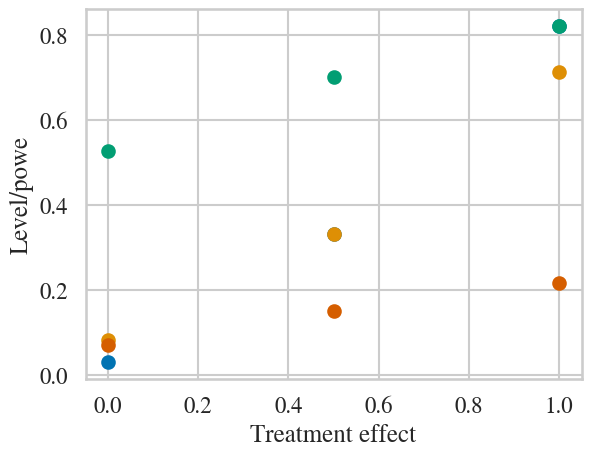

In [56]:
puiss_init = results.groupby("H0_coef").mean()["reject_H0_init"].to_numpy()
puiss_gen = results.groupby("H0_coef").mean()["reject_H0_gen"].to_numpy()
puiss_among_reject = results[results["reject_H0_init"] ==  True].groupby(["H0_coef"]).mean()["reject_H0_gen"].to_numpy()
puiss_among_accept = results[results["reject_H0_init"] ==  False].groupby(["H0_coef"]).mean()["reject_H0_gen"].to_numpy()
#puiss_among_accept = np.append(puiss_among_accept, np.nan)
plt.scatter(alphas,puiss_init,label = "All init.")
plt.scatter(alphas,puiss_gen,label = "All gen.")
plt.scatter(alphas,puiss_among_reject,label = "Gen. from reject")
plt.scatter(alphas,puiss_among_accept,label = "Gen. from accept")
#plt.plot(alphas,expected_power,label = "Expected level/power")
plt.xlabel("Treatment effect")
plt.ylabel("Level/power")
plt.savefig("./dataset/" + dataset_name + "/results_independent_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".jpeg")

## TODO point size should be proportional to sample size

## Dependent

In [50]:
M = 100
log_p_value = []
log_p_value_gen = []
simu_num = []
H0_coef = []
for t in alphas:
    treatment_effect = t
    for m in np.arange(M):
        if m % 10 == 0:
            print(m)
        control, treated =  simulation(beta_features, treatment_effect , n_samples, independent = False, surv_type = "surv_weibull",
                                     n_features_multiplier = 3, nnz = 3 , p_treated = 0.5, a_T = 2, a_C = 1, lamb_C = 0.15, 
                                     data_types_create = False)
        control = control.drop(columns='treatment')
        treated = treated.drop(columns='treatment')
        
        data_file_control= "./dataset/" + dataset_name + "/data_control_gen" + str(m) +".csv"
        data_file_treated= "./dataset/" + dataset_name + "/data_treated_gen" + str(m) +".csv"
        
        
        control.to_csv(data_file_control,index=False , header=False)
        treated.to_csv(data_file_treated,index=False , header=False)
        
        df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=fnames)
        df_init_control = pd.DataFrame(data_init_control.numpy(), columns=fnames)
        
        T_surv = torch.Tensor(df_init_control.time)
        T_surv_norm = (T_surv - T_surv.min()) / (T_surv.max() - T_surv.min())
        n_intervals = 5
        T_intervals = torch.linspace(0., T_surv_norm.max(), n_intervals)
        T_intervals = torch.cat([T_intervals, torch.tensor([2 * T_intervals[-1] - T_intervals[-2]])])
        intervals = [(T_intervals[i].item(), T_intervals[i + 1].item()) for i in range(len(T_intervals) - 1)]
        
        p_value_init = compute_logrank_test(control, treated)
    
        
    
        # Load and transform control data
        data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, 
                                                                                                                     feat_types_file_control, 
                                                                                                                     miss_file, true_miss_file)
        data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)
        
        # Load and transform treated data
        data_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, 
                                                                 miss_file, true_miss_file)
        data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)
    
        data_gen_control = surv_hivae.run((data_init_control_encoded, intervals), miss_mask_control, 
                                      true_miss_mask_control, feat_types_file_control, feat_types_dict, n_generated_dataset,verbose=False)
        
        for i in range(n_generated_dataset):
            df_gen_control = pd.DataFrame(data_gen_control[i].numpy(), columns=fnames)
            df_gen_control['treatment'] = 0
            log_p_value.append(p_value_init)
            simu_num.append(m)
            p_value_gen = compute_logrank_test(df_gen_control, treated)
            log_p_value_gen.append(p_value_gen)
            H0_coef.append(treatment_effect)

0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90


In [57]:

results = pd.DataFrame({'XP_num' : simu_num, "log_pvalue_init" : log_p_value, "log_pvalue_gen" : log_p_value_gen , "H0_coef" : H0_coef})
results["reject_H0_init"] = results['log_pvalue_init'] > -np.log(0.05)
results["reject_H0_gen"] = results['log_pvalue_gen'] > -np.log(0.05)

In [58]:
results.to_csv("./dataset/" + dataset_name + "results_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".csv")

In [59]:
alpha = 0.05
p_treated = 0.5
expected_power = []
for treatment_effect in np.arange(0,1.5,0.01):
    expected_power.append(norm.cdf(np.sqrt( D * p_treated * (1 - p_treated) * (treatment_effect)**2 ) - norm.ppf(1 - alpha/2)))

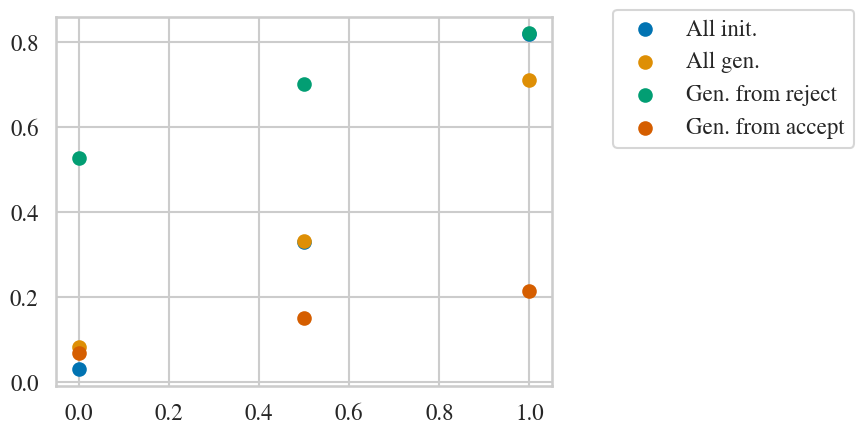

In [67]:
puiss_init = results.groupby("H0_coef").mean()["reject_H0_init"].to_numpy()
puiss_gen = results.groupby("H0_coef").mean()["reject_H0_gen"].to_numpy()
puiss_among_reject = results[results["reject_H0_init"] ==  True].groupby(["H0_coef"]).mean()["reject_H0_gen"].to_numpy()
puiss_among_accept = results[results["reject_H0_init"] ==  False].groupby(["H0_coef"]).mean()["reject_H0_gen"].to_numpy()
#puiss_among_accept = np.append(puiss_among_accept, np.nan)
plt.scatter(alphas,puiss_init,label = "All init.")
plt.scatter(alphas,puiss_gen,label = "All gen.")
plt.scatter(alphas,puiss_among_reject,label = "Gen. from reject")
plt.scatter(alphas,puiss_among_accept,label = "Gen. from accept")
#plt.plot(np.arange(0,1.5,0.01),expected_power,label = "Expected level/power")
plt.legend(bbox_to_anchor=(1.1, 1.05))